# Topology Solution

OSError: 

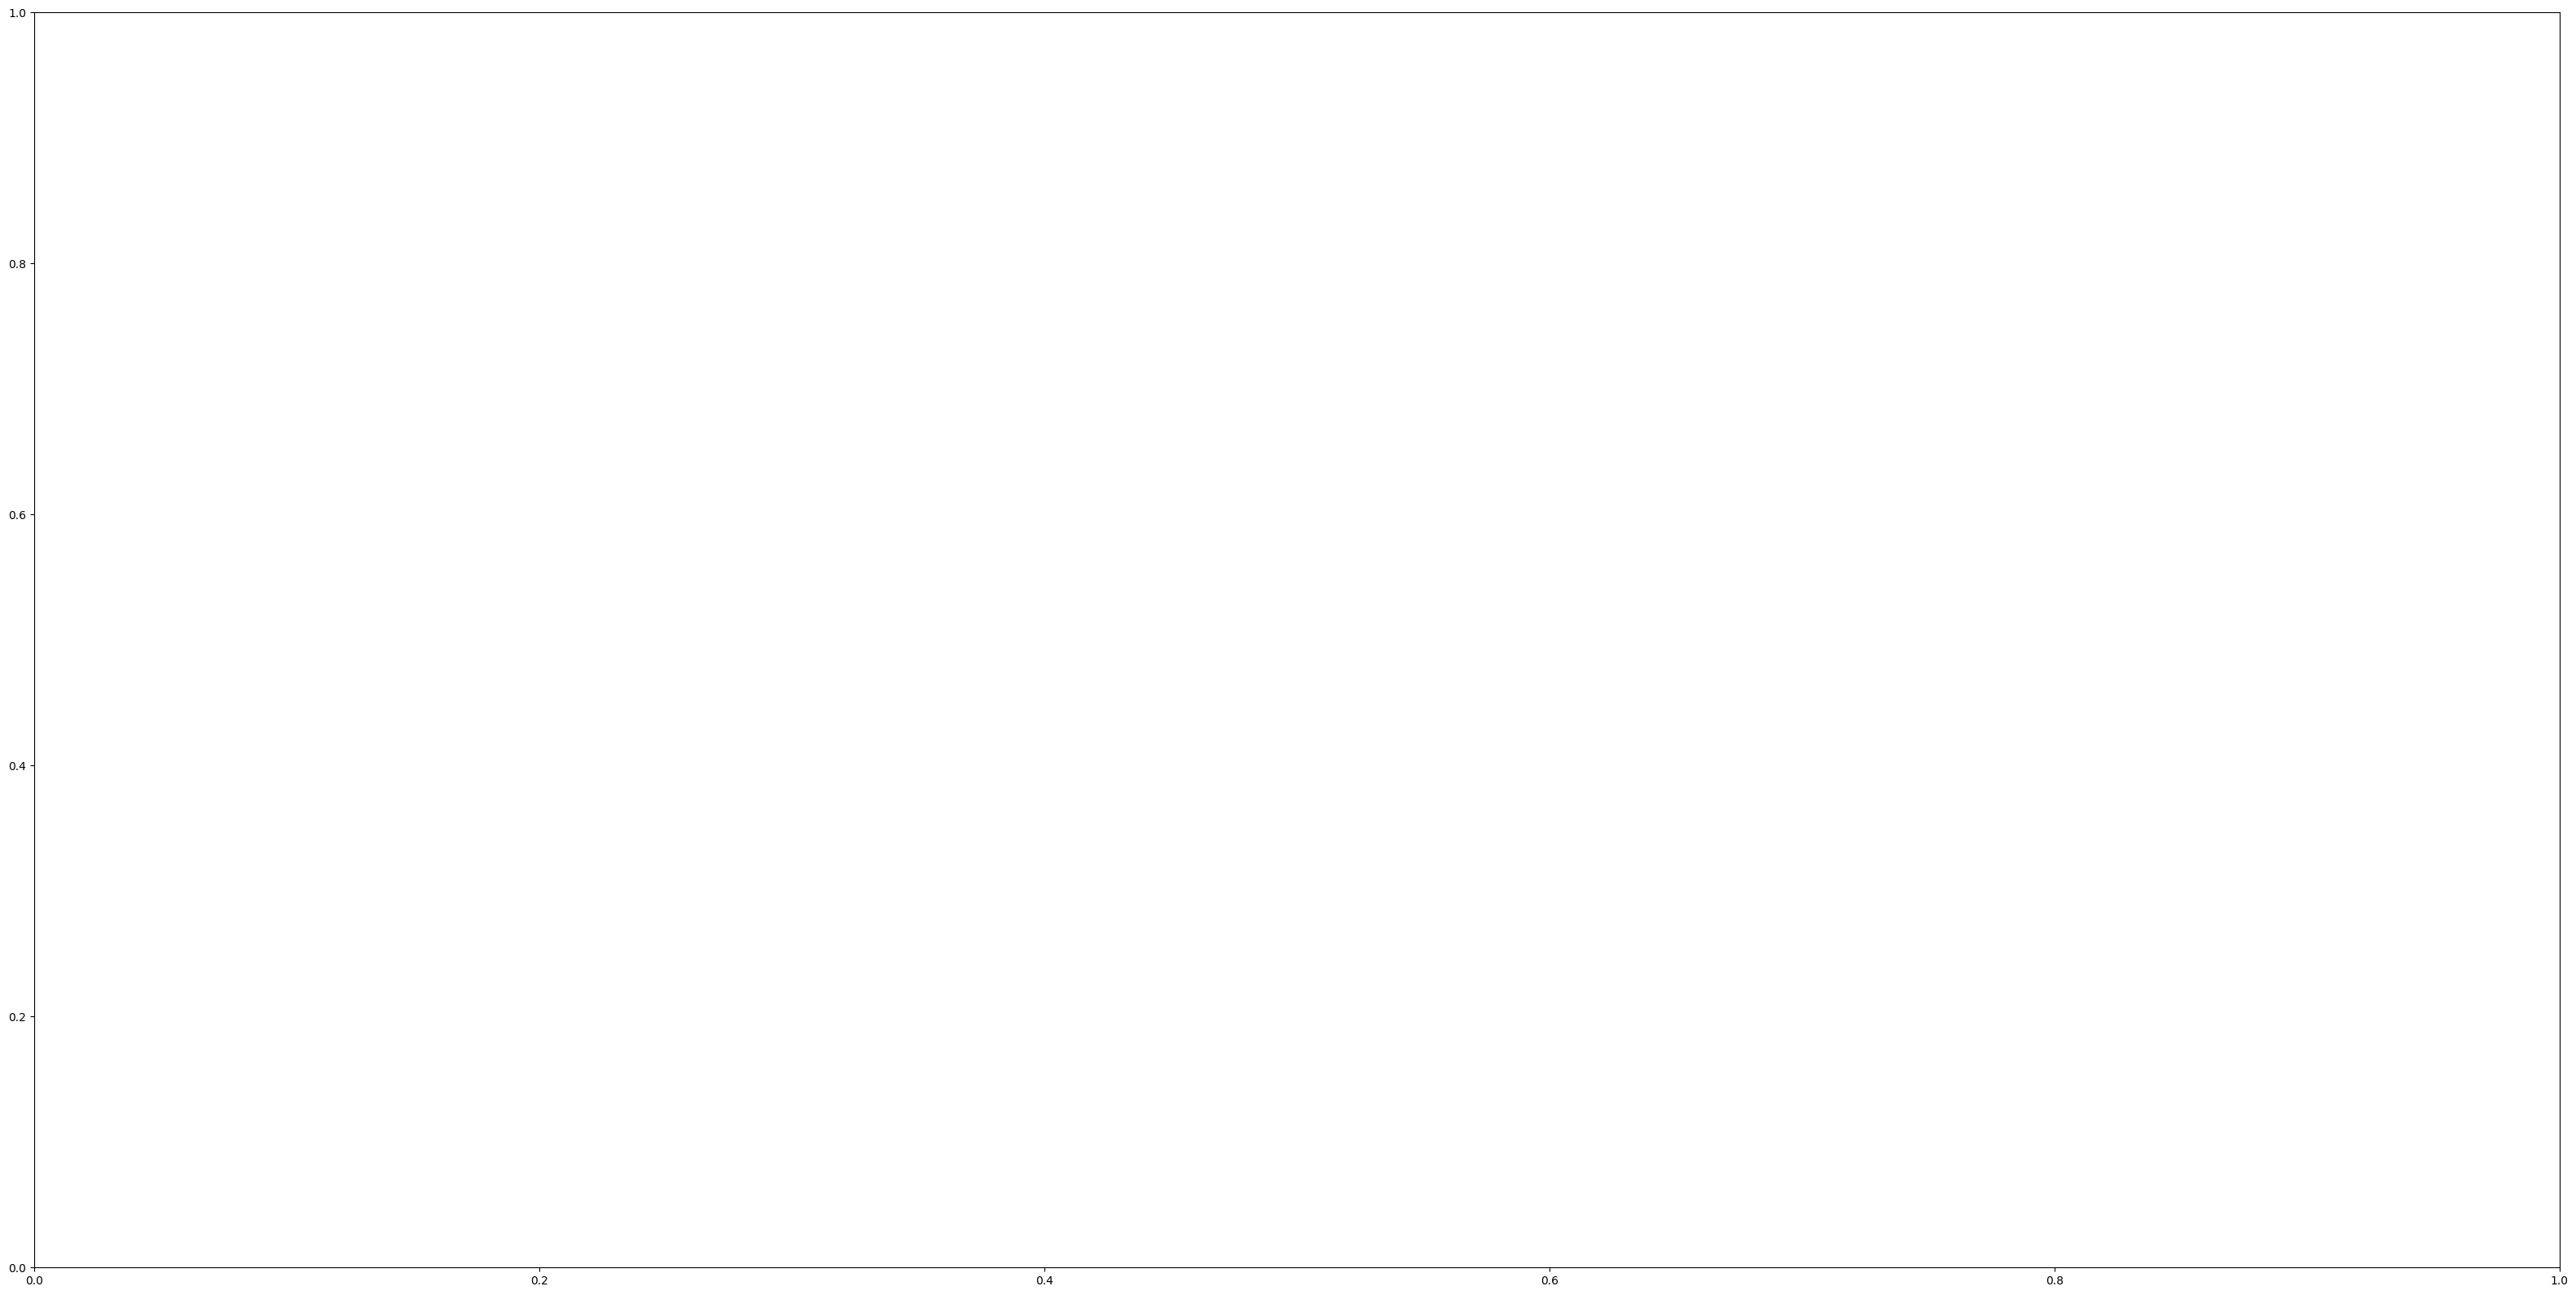

In [ ]:
import networkx as nx
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import pandas as pd
import os
from collections import defaultdict
import matplotlib.colors as mcolors

colors = {0:'#643299', 3:'#054AE3', 2:'#C84929', 1:'#DFAD23', 4:'#55AF01'}
NODES = "./data/EEPRAN_T2_50_nodes.json"
LINKS = "./data/EEPRAN_T2_50_links.json"
NET = "./solutions/2160p/topo_50_time_32_network.csv"
HW =  "./solutions/2160p/topo_50_time_32_hw.csv"
BS =  "./solutions/2160p/topo_50_time_32_drc_per_bs.csv"

p = "fig/T2_2160p_time_49.pdf"

drcs = {-1: "Core", 0: "No Split", 9: "Split 7.2", 62: "Split 6", 6: "Split 6, 7.2"}
mod = "dot"
x_ = 40
y_ = 20
    
def read_nodes_links(nodes, links):
    delays = {}
    capacities = {}
    usages = {}
    with open(links) as json_file:
        data_l = json.load(json_file)
    
    for l in data_l['links']:
        delays[(l['Node1'], l['Node2'])] = l['Delay']
        capacities[(int(l['Node1']), int(l['Node2']))] = l['PortCapacity']*l['NumLinks']
        
    df = pd.read_csv(NET)
    for idx, line in df.iterrows():
        if line['node1'] == line['node2']:
            continue
        n1 = int(line['node1'])
        n2 = int(line['node2'])
        usages[(n1, n2)] = line['usage']
    
    links = [(link, delays[link], usages[link], capacities[link]) for link in delays.keys()]

    with open(nodes) as json_file:
        data_n = json.load(json_file)
        
    df_hw = pd.read_csv(HW)
    hw_usage = defaultdict(float)
    for idx, line in df_hw.iterrows():
        hw_usage[line['hw']] = line['usage']
    
    df_bs = pd.read_csv(BS)
    bs_drc = {0: "Core"}
    for idx, line in df_bs.iterrows():
        bs_drc[int(line['bs'])] = drcs[int(line['drc'])]
        
    nodes = [(n['Number'], bs_drc[int(n['Number'])], hw_usage[n['Number']], 180) for n in data_n['nodes']]

    return nodes, links


def colors_rc(nodes):
    cores = [n[1] for n in nodes]
    cl = {}
    core_labels = list(dict.fromkeys(cores))
    # core_labels.sort()
    for item in range(len(core_labels)):
        cl[core_labels[item]] = colors[item]
    for item in range(len(cores)):
        cores[item] = cl[cores[item]]
    return cl, cores


def plot_graph(nodes, links, mod, x_, y_):

    nodes, links = read_nodes_links(nodes, links)
    
    G = nx.Graph()
    G.add_nodes_from([n[0] for n in nodes])
    
    core_labels, core_colors = colors_rc(nodes)

    for link, delay, usg, cap  in links:
        G.add_edge(link[0], link[1], weight="[{:.4f} / {} gbps]".format(usg, cap), color=mcolors.to_hex(plt.cm.winter(usg/16)))

    fig, ax = plt.subplots()
    fig.set_size_inches(x_, y_)

    print(G)
    pos = nx.nx_agraph.graphviz_layout(G, prog=mod)
    pos[5314] = (pos[5314][0]+100, pos[5314][1]) 
    pos[7314] = (pos[7314][0]-150, pos[7314][1]) 
    print(pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nodes_graph = nx.draw_networkx_nodes(G, pos, node_size=6000, node_color=core_colors, edgecolors='#000000')
    colors = nx.get_edge_attributes(G,'color').values()
    
    edges = nx.draw_networkx_edges(G, pos, arrowsize=10, edge_color=colors, style="-", width=10, edge_cmap=plt.cm.winter)
    
    # nx.draw_networkx_edge_labels(G, pos, edge_labels, font_color='#ff5050', font_size=10)
    lpos = {}
    labels = {}
    for node in nodes:
        if float(node[2]) == 0.0:
            continue
        num = node[0]
        lpos[num] = (pos[num][0], pos[num][1])
        labels[num] = "{}%".format(int(float(node[2])/float(node[3])*100))
    label_options = {"ec": "k", "fc": "black", "alpha": 0.6}
    nx.draw_networkx_labels(G, lpos, labels, font_color="white", font_weight="bold", bbox=label_options, font_size=45)
    
    plist = []
    for item in core_labels:
        pl, = (ax.plot([], [], "o", label=str(item), color=str(core_labels[item])))
        plist.append(pl)
    ax.legend(handles=plist, fontsize=56, loc='upper right', markerscale=5)
    
    for node, (x, y) in pos.items():
        text(x, y, "", fontsize=15, ha='center', va='center', color='#ffffff')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    cbar = fig.colorbar(edges, ticks=[0.01, 0.5, 0.99], format=matplotlib.ticker.FixedFormatter(['0', '8', '16']), 
                        orientation='horizontal', location="bottom", cax=cax)
    cbar.ax.tick_params(labelsize=64, labeltop=False, top=False, labelbottom=True, bottom=True)
    cbar.set_label(label="Link Throughput (Gbps)", size=64)
    
    # plt.title("eMBB 1440p - Timestamp 30")
    plt.savefig(p, bbox_inches='tight')
    print("Figure Saved: ", p)
    
    
    #plt.show()

if __name__ == '__main__':
    plot_graph(NODES, LINKS, mod, x_, y_)

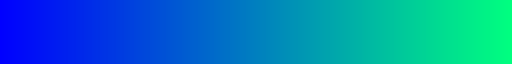

In [111]:
import numpy as np
import matplotlib
import matplotlib.colors as mcolors

# mcolors.to_hex(plt.cm.winter(0.9))
plt.cm.winter


# Qualitative Analysis

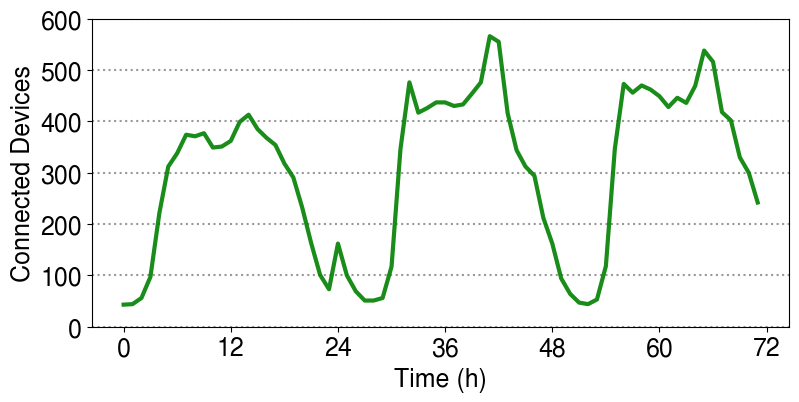

In [25]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_1080p = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_1440p = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_2160p = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.9

ax1.set_ylabel('Connected Devices', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)

ax1.yaxis.grid(color='gray', linestyle=':', linewidth=1.5, alpha=0.8)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
ax1.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=3, alpha=alpha, linestyle='-')

plt.xticks(range(0, 74, 12))
plt.ylim(0, 600)
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.legend('best')

# plt.show()
# plt.title("Base Station Load")
plt.savefig('fig/bs_load.pdf', bbox_inches='tight')


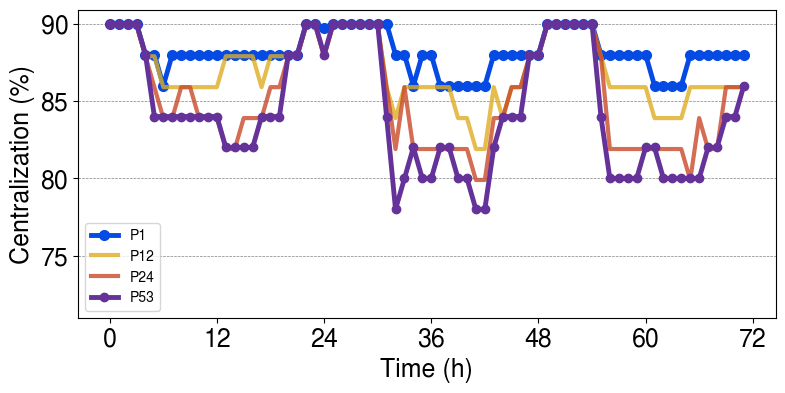

In [32]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_1080p = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_1440p = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_2160p = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Centralization (%)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_urllc['timestamp'][:72], df_urllc['centralization'][:72]/3.5 - 0.0, color=color2, lw=3.5, marker='o', ms=7, label='P1')
ax1.plot(df_urllc['timestamp'][:72], df_1080p['centralization'][:72]/3.5 - 0.1, color=color4, lw=3, alpha=0.8, label='P12')
ax1.plot(df_urllc['timestamp'][:72], df_1440p['centralization'][:72]/3.5 - 0.1, color=color3, lw=3, alpha=0.8, label='P24')
ax1.plot(df_urllc['timestamp'][:72], df_2160p['centralization'][:72]/3.5 - 0.0, color=color1, lw=3.5, marker='o', ms=6, label='P53')

ax1.set_ylim(70.99499999999973, 90.90500000000003)
# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='lower left')

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')
# 
# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# # ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
# 
# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=3, alpha=alpha, linestyle=':')
# 
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
# plt.title("Centralização por Tipo de Serviço")
plt.savefig('fig/centralization_service.pdf', bbox_inches='tight')


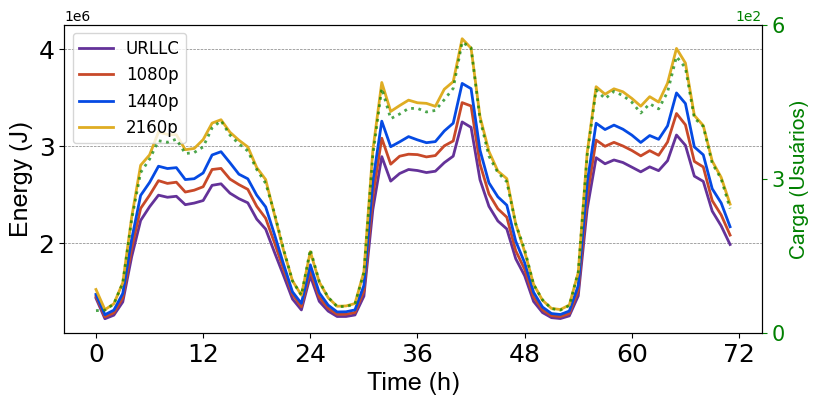

In [31]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_1080p = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_1440p = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_2160p = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Energy (J)', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Time (h)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

df_urllc['energy'] = df_urllc['ranEnergy'] + df_urllc['migEnergy'] + df_urllc['netEnergy']
df_1080p['energy'] = df_1080p['ranEnergy'] + df_1080p['migEnergy'] + df_1080p['netEnergy']
df_1440p['energy'] = df_1440p['ranEnergy'] + df_1440p['migEnergy'] + df_1440p['netEnergy']
df_2160p['energy'] = df_2160p['ranEnergy'] + df_2160p['migEnergy'] + df_2160p['netEnergy']

ax1.plot(df_urllc['timestamp'][:72], df_urllc['energy'][:72], lw=2, color=color1, label='URLLC')
ax1.plot(df_urllc['timestamp'][:72], df_1080p['energy'][:72], lw=2, color=color3, label='1080p')
ax1.plot(df_urllc['timestamp'][:72], df_1440p['energy'][:72], lw=2, color=color2, label='1440p')
ax1.plot(df_urllc['timestamp'][:72], df_2160p['energy'][:72], lw=2, color=color4, label='2160p')

# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left', fontsize=12)

# ------------
# SCATTER PLOT
# ------------

df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
ax2 = ax1.twinx()
ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')

ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
ax2.tick_params(axis='x', which='major', labelsize=15)
# ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')

plt.yticks([0, 300, 600])
plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy.pdf', bbox_inches='tight')


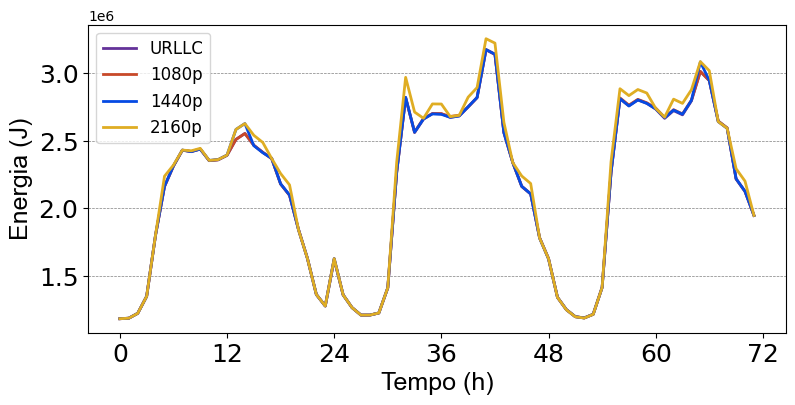

In [28]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_1080p = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_1440p = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_2160p = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Energia (J)', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Tempo (h)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

# df_urllc['energy'] = df_urllc['ranEnergy'] + df_urllc['migEnergy'] + df_urllc['netEnergy']
# df_1080p['energy'] = df_1080p['ranEnergy'] + df_1080p['migEnergy'] + df_1080p['netEnergy']
# df_1440p['energy'] = df_1440p['ranEnergy'] + df_1440p['migEnergy'] + df_1440p['netEnergy']
# df_2160p['energy'] = df_2160p['ranEnergy'] + df_2160p['migEnergy'] + df_2160p['netEnergy']

df_urllc['energy'] = df_urllc['ranEnergy']
df_1080p['energy'] = df_1080p['ranEnergy']
df_1440p['energy'] = df_1440p['ranEnergy']
df_2160p['energy'] = df_2160p['ranEnergy']

ax1.plot(df_urllc['timestamp'][:72], df_urllc['energy'][:72], lw=2, color=color1, label='URLLC')
ax1.plot(df_urllc['timestamp'][:72], df_1080p['energy'][:72], lw=2, color=color3, label='1080p')
ax1.plot(df_urllc['timestamp'][:72], df_1440p['energy'][:72], lw=2, color=color2, label='1440p')
ax1.plot(df_urllc['timestamp'][:72], df_2160p['energy'][:72], lw=2, color=color4, label='2160p')

# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left', fontsize=12)

# ------------
# SCATTER PLOT
# ------------

df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')

# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')

# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
# plt.title("Energia da RAN")
plt.savefig('fig/ran_energy.pdf', bbox_inches='tight')


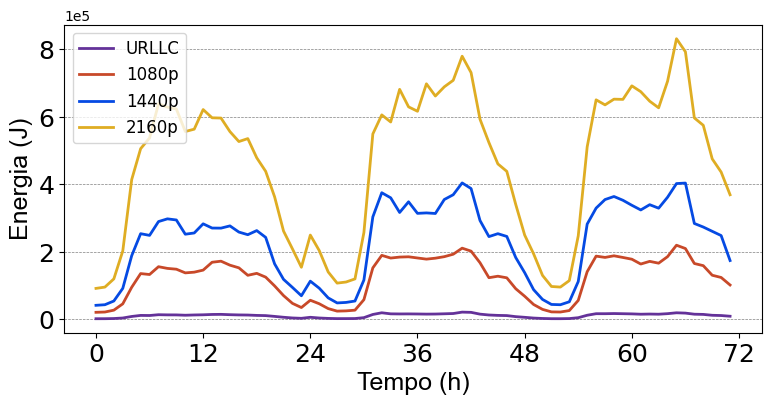

In [39]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_1080p = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_1440p = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_2160p = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Energia (J)', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Tempo (h)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

# df_urllc['energy'] = df_urllc['ranEnergy'] + df_urllc['migEnergy'] + df_urllc['netEnergy']
# df_1080p['energy'] = df_1080p['ranEnergy'] + df_1080p['migEnergy'] + df_1080p['netEnergy']
# df_1440p['energy'] = df_1440p['ranEnergy'] + df_1440p['migEnergy'] + df_1440p['netEnergy']
# df_2160p['energy'] = df_2160p['ranEnergy'] + df_2160p['migEnergy'] + df_2160p['netEnergy']

# df_urllc['energy'] = df_urllc['ranEnergy']
# df_1080p['energy'] = df_1080p['ranEnergy']
# df_1440p['energy'] = df_1440p['ranEnergy']
# df_2160p['energy'] = df_2160p['ranEnergy']

df_urllc['energy'] = df_urllc['netEnergy']
df_1080p['energy'] = df_1080p['netEnergy']
df_1440p['energy'] = df_1440p['netEnergy']
df_2160p['energy'] = df_2160p['netEnergy']

ax1.plot(df_urllc['timestamp'][:72], df_urllc['energy'][:72], lw=2, color=color1, label='URLLC')
ax1.plot(df_urllc['timestamp'][:72], df_1080p['energy'][:72], lw=2, color=color3, label='1080p')
ax1.plot(df_urllc['timestamp'][:72], df_1440p['energy'][:72], lw=2, color=color2, label='1440p')
ax1.plot(df_urllc['timestamp'][:72], df_2160p['energy'][:72], lw=2, color=color4, label='2160p')

# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left', fontsize=12)

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')

# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')

# plt.yticks([0, 300, 600])
plt.ticklabel_format(axis='y', style='sci', scilimits=(3,5))

# plt.show()
# plt.title("Energia da Rede de Transporte")
plt.savefig('fig/net_energy.pdf', bbox_inches='tight')


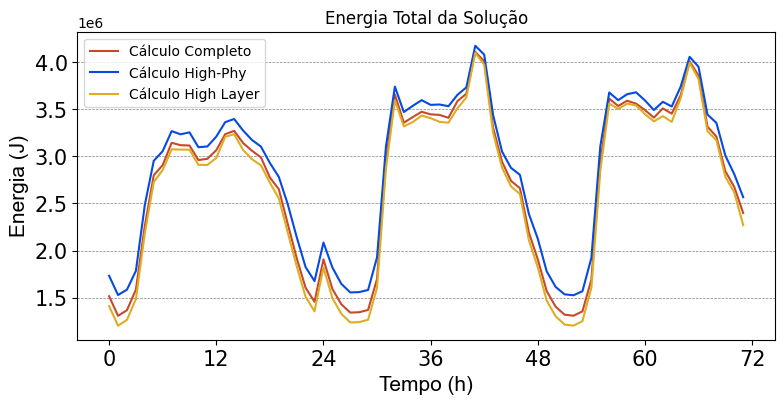

In [87]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_calc = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')
df_hp = pandas.read_csv("solutions/hp_2160p/topo_50.csv", sep=',')
df_hl = pandas.read_csv("solutions/hl_2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Energia (J)', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Tempo (h)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

df_calc['energy'] = df_calc['ranEnergy'] + df_calc['migEnergy'] + df_calc['netEnergy']
df_hp['energy'] = df_hp['ranEnergy'] + df_hp['migEnergy'] + df_hp['netEnergy']
df_hl['energy'] = df_hl['ranEnergy'] + df_hl['migEnergy'] + df_hl['netEnergy']

ax1.plot(df_calc['timestamp'][:72], df_calc['energy'][:72], color=color3, label='Cálculo Completo')
ax1.plot(df_hp['timestamp'][:72], df_hp['energy'][:72], color=color2, label='Cálculo High-Phy')
ax1.plot(df_hl['timestamp'][:72], df_hl['energy'][:72], color=color4, label='Cálculo High Layer')

# plt.yticks([0, 2000000])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left')

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')
# 
# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# # ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
# 
# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')
# 
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
plt.title("Energia Total da Solução")
plt.savefig('fig/energy_calc.pdf', bbox_inches='tight')


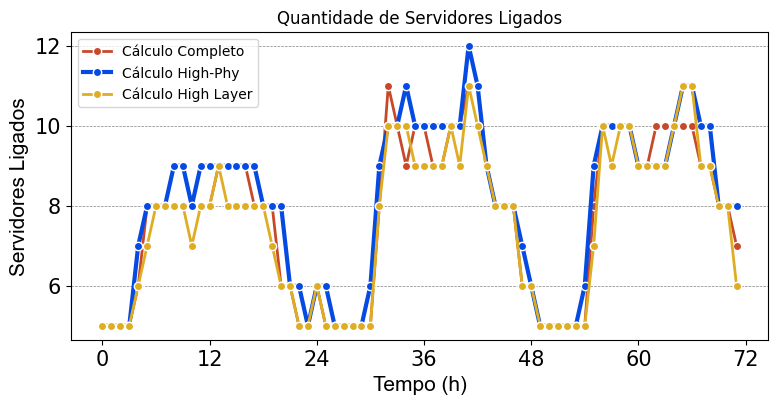

In [88]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_calc = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')
df_hp = pandas.read_csv("solutions/hp_2160p/topo_50.csv", sep=',')
df_hl = pandas.read_csv("solutions/hl_2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Servidores Ligados', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Tempo (h)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax1.plot(df_calc['timestamp'][:72], df_calc['usedMachines'][:72], color=color3, lw=2, marker="o", mec="White", label='Cálculo Completo')
ax1.plot(df_hp['timestamp'][:72], df_hp['usedMachines'][:72], color=color2, lw=3, marker="o", mec="White", label='Cálculo High-Phy')
ax1.plot(df_hl['timestamp'][:72], df_hl['usedMachines'][:72], color=color4, lw=2, marker="o", mec="White", label='Cálculo High Layer')
    
# plt.yticks([0, 2000000])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left')

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')
# 
# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# # ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
# 
# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')
# 
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
plt.title("Quantidade de Servidores Ligados")
plt.savefig('fig/used_machines.pdf', bbox_inches='tight')


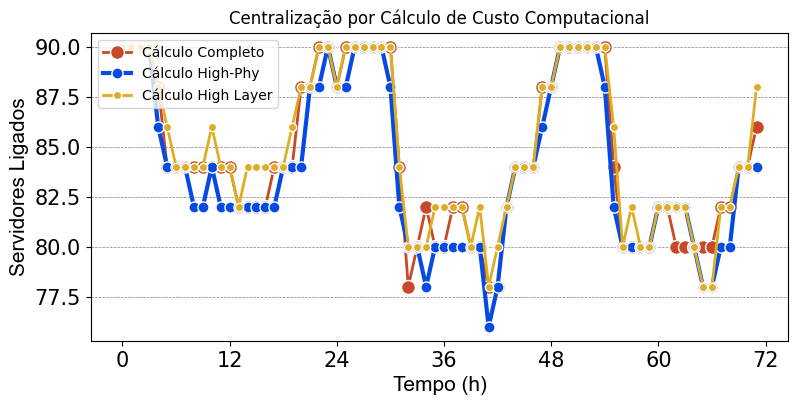

In [90]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_calc = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')
df_hp = pandas.read_csv("solutions/hp_2160p/topo_50.csv", sep=',')
df_hl = pandas.read_csv("solutions/hl_2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Servidores Ligados', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Tempo (h)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax1.plot(df_calc['timestamp'][:72], df_calc['centralization'][:72]/3.5, color=color3, lw=2, marker="o", mec="White", ms=10, label='Cálculo Completo')
ax1.plot(df_hp['timestamp'][:72], df_hp['centralization'][:72]/3.5, color=color2, lw=3, marker="o", mec="White", ms=8, label='Cálculo High-Phy')
ax1.plot(df_hl['timestamp'][:72], df_hl['centralization'][:72]/3.5, color=color4, lw=2, marker="o", mec="White", ms=6, label='Cálculo High Layer')
    
# plt.yticks([0, 2000000])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left')

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')
# 
# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# # ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
# 
# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')
# 
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
plt.title("Centralização por Cálculo de Custo Computacional")
plt.savefig('fig/centralization_calc.pdf', bbox_inches='tight')


6.5470000000000255


<Axes: >

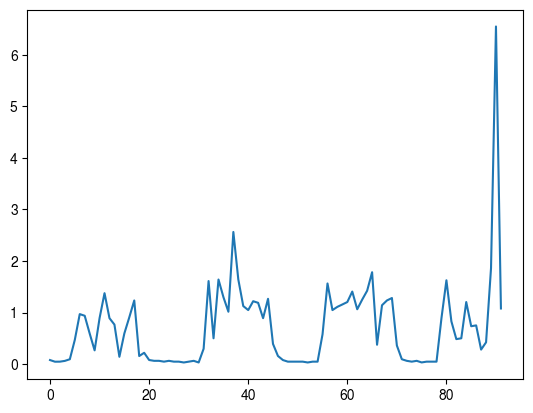

In [21]:
import pandas
import numpy as np

# df = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')
df = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
print(np.max(df['solveTime']))
df['solveTime'].plot()

# Quantitative Analysis

10.815476190476325


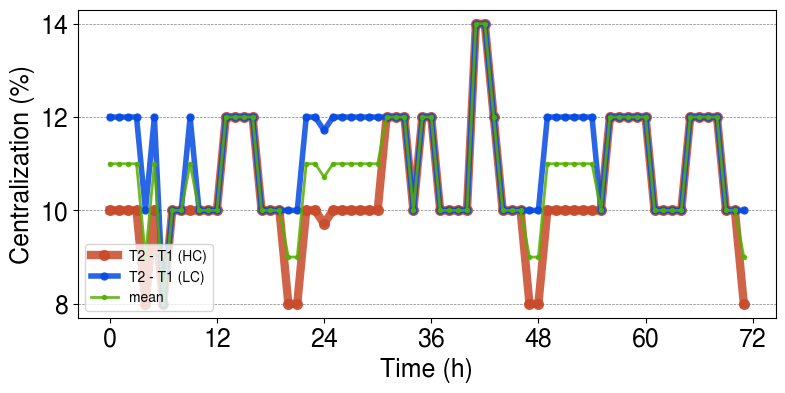

In [34]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t2_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_t2_1080 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_t2_1440 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_t2_2160 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1_urllc = pandas.read_csv("solutions/T1_urllc/topo_50.csv", sep=',')
df_t1_1080 = pandas.read_csv("solutions/T1_1080p/topo_50.csv", sep=',')
df_t1_1440 = pandas.read_csv("solutions/T1_1440p/topo_50.csv", sep=',')
df_t1_2160 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')

df_t1_urllc_lc = pandas.read_csv("solutions/T1_LC_urllc/topo_50.csv", sep=',')
df_t1_1080_lc = pandas.read_csv("solutions/T1_LC_1080p/topo_50.csv", sep=',')
df_t1_1440_lc = pandas.read_csv("solutions/T1_LC_1440p/topo_50.csv", sep=',')
df_t1_2160_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Centralization (%)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_t1_urllc['timestamp'][:72],  df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc['centralization'][:72]/3.5, 
         color=color3, lw=6, alpha=0.85, marker='o', ms=7, label='T2 - T1 (HC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72],  df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc_lc['centralization'][:72]/3.5, 
         color=color2, lw=4, alpha=0.85, marker='o', ms=5, label='T2 - T1 (LC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72],  (df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc_lc['centralization'][:72]/3.5 + df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc['centralization'][:72]/3.5)/2, 
         color=color5, lw=2, alpha=0.85, marker='o', ms=3, label='mean')

a = np.mean(df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc_lc['centralization'][:72]/3.5)
b = np.mean(df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc['centralization'][:72]/3.5)

print(np.mean([a, b]))

plt.xticks(range(0, 74, 12))
plt.legend(loc='lower left')

plt.show()


15.178571428572345
9.833333333333826
12.505952380953087


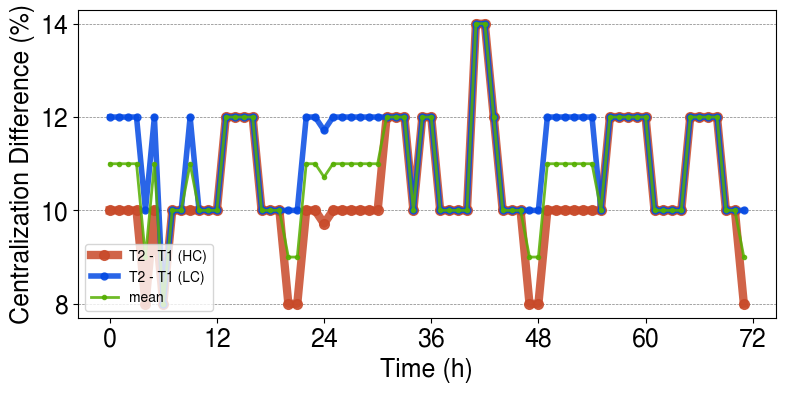

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t2_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_t2_1080 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_t2_1440 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_t2_2160 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1_urllc = pandas.read_csv("solutions/T1_urllc/topo_50.csv", sep=',')
df_t1_1080 = pandas.read_csv("solutions/T1_1080p/topo_50.csv", sep=',')
df_t1_1440 = pandas.read_csv("solutions/T1_1440p/topo_50.csv", sep=',')
df_t1_2160 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')

df_t1_urllc_lc = pandas.read_csv("solutions/T1_LC_urllc/topo_50.csv", sep=',')
df_t1_1080_lc = pandas.read_csv("solutions/T1_LC_1080p/topo_50.csv", sep=',')
df_t1_1440_lc = pandas.read_csv("solutions/T1_LC_1440p/topo_50.csv", sep=',')
df_t1_2160_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')


fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Centralization Difference (%)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_t1_urllc['timestamp'][:72],  df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc['centralization'][:72]/3.5, 
         color=color3, lw=6, alpha=0.85, marker='o', ms=7, label='T2 - T1 (HC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72],  df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc_lc['centralization'][:72]/3.5, 
         color=color2, lw=4, alpha=0.85, marker='o', ms=5, label='T2 - T1 (LC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72],  (df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc_lc['centralization'][:72]/3.5 + df_t2_urllc['centralization'][:72]/3.5 - df_t1_urllc['centralization'][:72]/3.5)/2, 
         color=color5, lw=2, alpha=0.85, marker='o', ms=3, label='mean')

a = np.mean(df_t2_2160['centralization'][:72]/3.5 - df_t1_2160_lc['centralization'][:72]/3.5)
b = np.mean(df_t2_2160['centralization'][:72]/3.5 - df_t1_2160['centralization'][:72]/3.5)

print(a)
print(b)
print(np.mean([a, b]))

plt.xticks(range(0, 74, 12))
plt.legend(loc='lower left')

plt.show()


0.7263022107045022
0.8260339535767982
0.7761680821406503


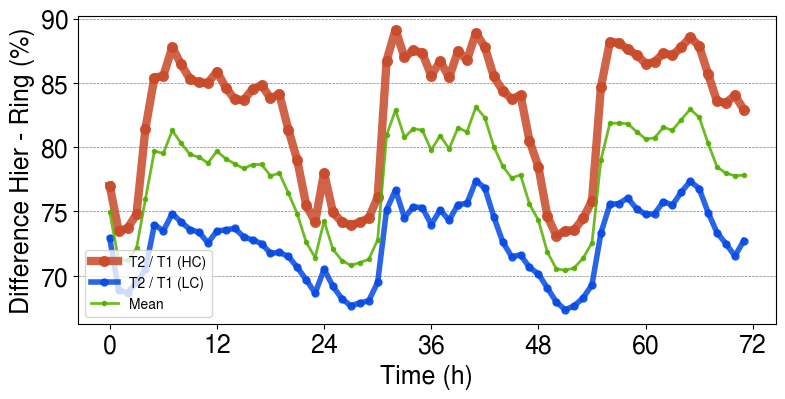

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t2_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_t2_2160 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1_urllc = pandas.read_csv("solutions/T1_urllc/topo_50.csv", sep=',')
df_t1_2160 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')

df_t1_urllc_lc = pandas.read_csv("solutions/T1_LC_urllc/topo_50.csv", sep=',')
df_t1_2160_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')

df_t1_urllc['energy'] = df_t1_urllc['ranEnergy'] + df_t1_urllc['migEnergy'] + df_t1_urllc['netEnergy']
df_t1_urllc_lc['energy'] = df_t1_urllc_lc['ranEnergy'] + df_t1_urllc_lc['migEnergy'] + df_t1_urllc_lc['netEnergy']
df_t2_urllc['energy'] = df_t2_urllc['ranEnergy'] + df_t2_urllc['migEnergy'] + df_t2_urllc['netEnergy']

df_t1_2160['energy'] = df_t1_2160['ranEnergy'] + df_t1_2160['migEnergy'] + df_t1_2160['netEnergy']
df_t1_2160_lc['energy'] = df_t1_2160_lc['ranEnergy'] + df_t1_2160_lc['migEnergy'] + df_t1_2160_lc['netEnergy']
df_t2_2160['energy'] = df_t2_2160['ranEnergy'] + df_t2_2160['migEnergy'] + df_t2_2160['netEnergy']

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Difference Hier - Ring (%)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_t2_2160['timestamp'][:72], 100 * df_t2_2160['energy'][:72] / df_t1_2160['energy'][:72], 
         color=color3, lw=6, alpha=0.85, marker='o', ms=7, label='T2 / T1 (HC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72], 100 * df_t2_2160['energy'][:72] / df_t1_2160_lc['energy'][:72], 
         color=color2, lw=4, alpha=0.85, marker='o', ms=5, label='T2 / T1 (LC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72], 100 *  (df_t2_2160['energy'][:72] / df_t1_2160_lc['energy'][:72] + df_t2_2160['energy'][:72] / df_t1_2160['energy'][:72])/2, 
         color=color5, lw=2, alpha=0.85, marker='o', ms=3, label='Mean')

a = np.mean(df_t2_2160['energy'][:72] / df_t1_2160_lc['energy'][:72])
b = np.mean(df_t2_2160['energy'][:72] / df_t1_2160['energy'][:72])

print(a)
print(b)
print(np.mean([a, b]))

plt.xticks(range(0, 74, 12))
plt.legend(loc='lower left')

plt.show()
